# Part A: Classification of Customer Defaulting Payment


**<font size=4>
Prediction Task**

**How is your prediction task defined?**

This dataset contains data on customer information owned by a bank. It also includes the status (i.e. default/no default) as well as other information such as bill and payment amounts of customers. If a customer defaults on their payments, it is bad for a bank as this could lead to harmful consequences such as a loss of revenue. 

Hence, the task is to create a classication model that predicts whether a customer would default thier payment based on cutomer features

**What is the meaning of the output variable?**

The output variable, Default payment next month, contains two class labels: 0 or 1. A status of 0 means that the customer will pay the bill (non-default), where a status of 1 indicates that the customer will not pay the bill (default).

# **BACKGROUND RESEARCH**

<h3>What does human level performance look like for this problem?<h3>
INCOMPLETE

# References

* scikit link...
* cramer v link...
* background research link...
* dataset source

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt 
from numpy.random import rand

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict, cross_val_score, validation_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# Preprocessing
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import learning_curve, ShuffleSplit

# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn import svm


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2, mutual_info_classif

from warnings import filterwarnings 
filterwarnings('ignore')

# Defining Utility functions

Functions that will be used

In [4]:
# Scoring models
def score_models(X_train, y_train, models, metrics, cv):
    scores = []

    for name, model in models:
        model.fit(X_train, y_train)
        cv_score = cross_validate(model, X_train, y_train, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
        scores.append(pd.Series(cv_score, name=name).apply(np.mean, axis=0))
        metrics_scores = pd.DataFrame(scores)

    return metrics_scores

# Plot learning curve
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):
    
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='recall', n_jobs=-1, train_sizes=train_sizes)

    # Create means and standard deviations of training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    plt.plot(train_sizes, train_scores_mean, 'o--', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-Validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)

    plt.xlabel('Training set size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title(f'Learning Curve {title}')
    return plt

def plot_validation_curve_range(estimator, X_train, y_train, parameter_name, parameter_range):
    train_scores, test_scores = validation_curve(
        estimator=estimator,
        X=X_train,
        y=y_train,
        param_name=parameter_name,
        param_range=parameter_range,
        scoring="recall",
        n_jobs=-1
    )

    # Create means and standard deviations of training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting
    plt.plot(
        parameter_range, train_scores_mean, 'o--',label="Training score", color="navy", lw=2
    )
    
    plt.fill_between(parameter_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, lw=2)
    
    plt.plot(
        parameter_range, test_scores_mean, 'o-', label="Cross-validation score", color="darkorange", lw=2
    )
    
    plt.fill_between(parameter_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, lw=2)

    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Score')
    plt.ylim(0.0,1.1)
    plt.legend(loc='best')
    plt.title(f'Validation Curve with ExtraTreesClassifier')
    return plt

# Data Exploration

* Conduct an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.
* To prevent the mutation of original data, I will make a copy to perform EDA on it
* The data set is constructed from the bank infromation of 1600 customers

**Metadata**
* Customer ID: Unique customer identifier ranging from 1 to 1600
* Credit Limit: The  credit limit for the customer
* Gender: Customer gender
* Education: Customer education level
* Marriage Status: Customer marital status
* Age: Rotational Customer age
* Bill_Amount1: Customer credit card bill amount 1 month ago
* Bill_Amount2: Customer credit card bill amount 2 month ago
* Bill_Amount3: Customer credit card bill amount 3 month ago
* Pay_Amount1: The amount customer paid 1 month ago
* Pay_Amount2: The amount customer paid 2 month ago
* Pay_Amount3: The amount customer paid 3 month ago
* Default payment next month: Whether customer will default next month, 1 means default (customer will not pay the bill), 0 means non default (customer will pay the bill)

In [5]:
# Import the dataset
credit_df = pd.read_csv('credit_dataset.csv')
credit_df

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1596,480000,female,univeresity,married,35,18214,11031,182123,0,182123,12960,0
1596,1597,150000,female,univeresity,married,37,1184,794,2756,0,2772,0,0
1597,1598,110000,female,post-graduate,single,29,107195,109443,106637,7845,4000,4000,0
1598,1599,240000,male,post-graduate,single,30,7744,7284,11234,7305,11263,10018,0


In [6]:
credit_eda = credit_df.copy()

# Descriptive Analysis

In [7]:
credit_eda.shape

(1600, 13)

This dataset has 1600 rows and 13 columns.

In [8]:
credit_eda.head(5)

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


* Taking a look at the first 5 rows of data, majority of columns contain numerical data
* Gender, Education and Marriage Status column contains categorical (nominal) data, which may need to be encoded later on.
* Customer ID contain identifiers for each customer.
* As this value does not provide any insight to my analysis, it would be best to drop this column.

In [9]:
descriptive_stats = credit_eda.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
Customer ID,1600.0,800.500000,462.024530,1.0,400.75,800.5,1200.25,1600.0
Credit Limit,1600.0,166787.500000,129944.635707,10000.0,50000.00,140000.0,230000.00,700000.0
Age,1600.0,35.224375,9.404550,21.0,28.00,34.0,41.00,75.0
Bill_Amount1,1600.0,49263.408125,72687.106917,-14386.0,3138.00,20320.5,61602.75,507726.0
Bill_Amount2,1600.0,47726.644375,71476.217397,-13543.0,3288.25,19769.5,59891.75,509229.0
Bill_Amount3,1600.0,44531.051875,67164.064239,-9850.0,2321.50,19332.5,53857.25,499936.0
Pay_Amount1,1600.0,5547.646250,14085.471957,0.0,1000.00,2176.5,5021.00,239104.0
Pay_Amount2,1600.0,5230.494375,15569.605419,0.0,468.50,1904.0,4592.50,285138.0
Pay_Amount3,1600.0,4451.610625,12491.715387,0.0,226.50,1313.5,4000.00,222750.0
Default payment next month,1600.0,0.212500,0.409205,0.0,0.00,0.0,0.00,1.0


* The columns Credit Limit, Bill_Amount1, Bill_Amount2, Bill_Amount3, Pay_Amount1, Pay_Amount2, Pay_Amount3 contains values of high magnitude compared to others columns, and thus they will need to be scaled.

In [10]:
credit_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 162.6+ KB


* This dataset has no null values present
* Credit Limit, Age, Bill_Amount1, Bill_Amount2, Bill_Amount3, Pay_Amount1, Pay_Amount2, Pay_Amount3 are all continuous features
* Looking at the bill and pay features, it may be possible to engineer new features like Total_Bill and Total_Paymrnt for our model to use (however these may not be useful as forfeiting the specific bill informations may not allow our model to identify patterns ect)
* We will test the model with both the new and old features to see whihc produces a better result

# Univariate Analysis

**<font size = 3>
Output Variable**

Our output variable is the Default payment next month column. It is a binary column with two values:

* 0: Non Default 
* 1: Default

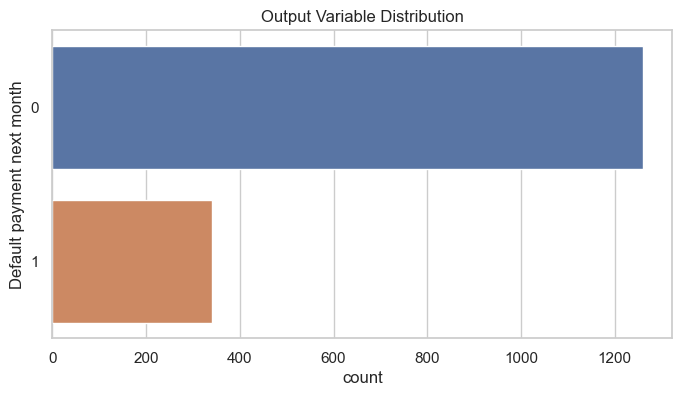

In [11]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Default payment next month'])
plt.title('Output Variable Distribution')
plt.show()

* Target feature is quite imbalanced with most customers not defaulting on payment.
* This suggests that defaulting payments is a rarer occurence compared to not defaulting
* An unbalanced dataset will bias the prediction model towards the majority class. Hence, it will need to be dealth with.
* There two approaches when dealing with imbalanced classes.
* Oversampling: Takes random samples for the minority class (default) and duplicates those samples to the length of the majority class (non default).
* Undersampling: Removes random samples from the majority class (non default) to the length of the minority class (default).
* Because undersampling will severely reduce the size of the dataset, the better approach would be to use oversampling.

**<font size = 3>
Age Distribution**

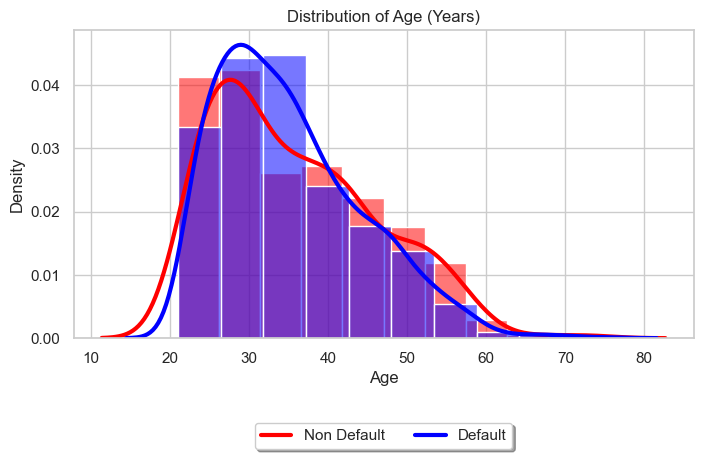

In [12]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Age'],
    density=True,
#     bins=20,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Age'],
    density=True,
#     bins=20,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Age"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Age"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Age (Years)")
plt.show()

* We see that the age of customers is positively skewed with the right tail extending 

**<font size = 3>
Credit Limit Distribution**

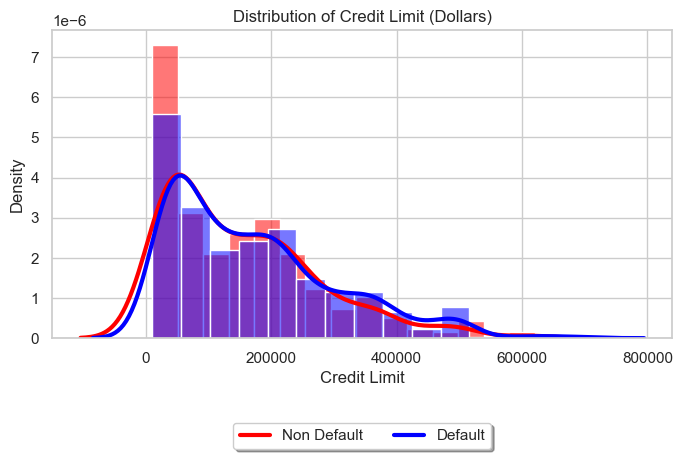

In [13]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Credit Limit'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Credit Limit'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Credit Limit"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Credit Limit"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Credit Limit (Dollars)")
plt.show()

**<font size=3>
Bill_Amount1, Bill_Amount2, Bill_Amount3 Distribution**

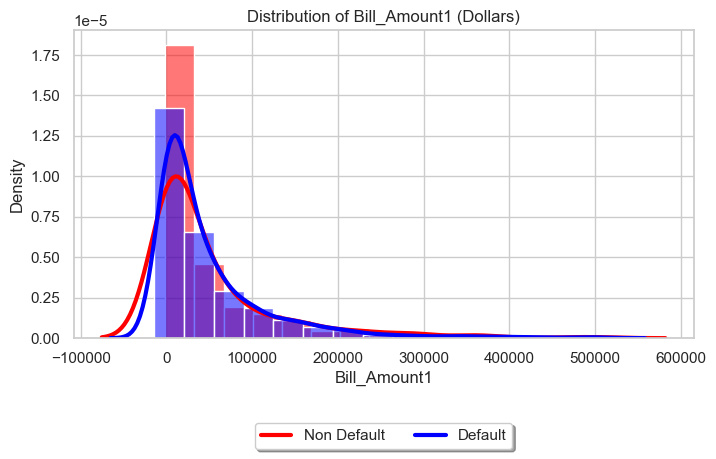

In [14]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount1'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount1'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount1"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount1"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount1 (Dollars)")
plt.show()

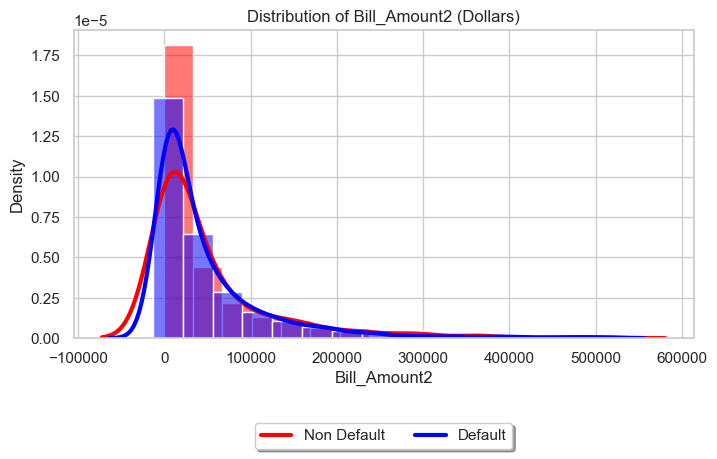

In [15]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount2'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount2'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount2"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount2"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount2 (Dollars)")
plt.show()

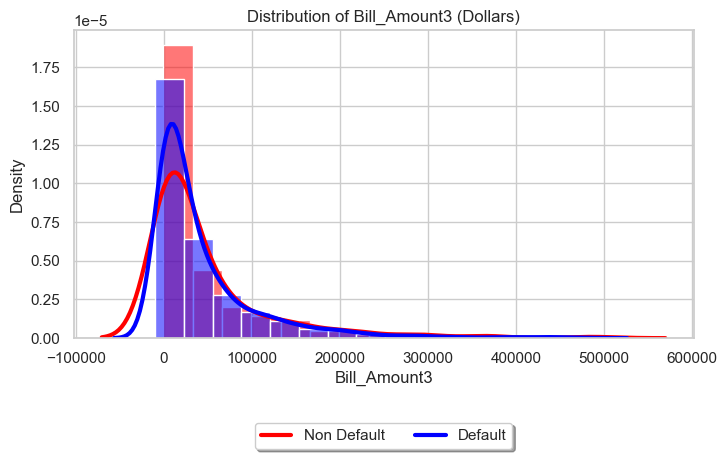

In [16]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Bill_Amount3'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Bill_Amount3'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Bill_Amount3"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Bill_Amount3"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Bill_Amount3 (Dollars)")
plt.show()

* From the graphs we see that the bill amount features are rougly have the same distribution as each other
* Their distribution is positively skewed with the right tail extending
* Notice that there are negative values for bills, this is because some customers may overay their bill, the negative values are an indicator of how much was overpayed (bill - payment)
* Thus, such values do not need to be dealt with (left alone)
* May need to be normalized with log scale or standard scaler

**<font size=3>
 Pay_Amount1, Pay_Amount2, Pay_Amount3 Distribution**

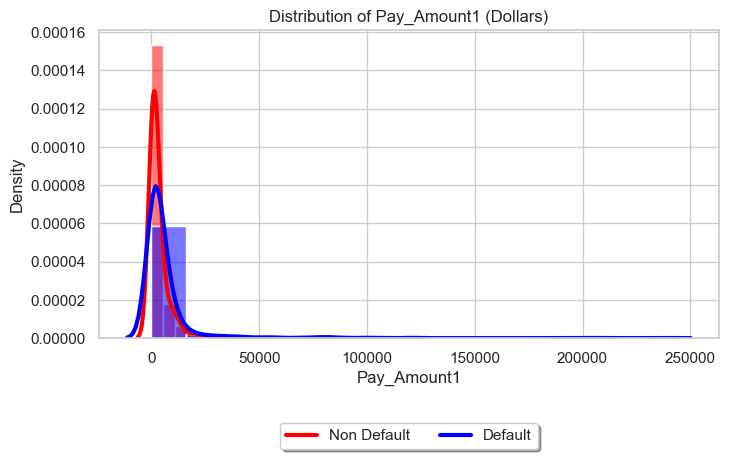

In [17]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount1'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount1'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount1"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount1"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount1 (Dollars)")
plt.show()

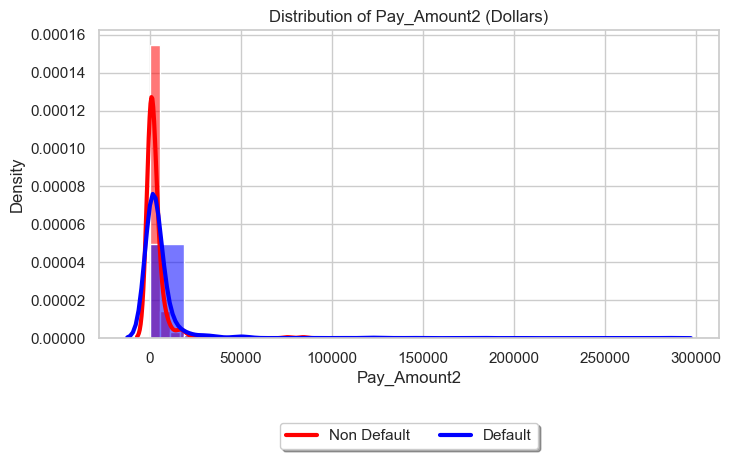

In [18]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount2'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount2'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount2"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount2"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount2 (Dollars)")
plt.show()

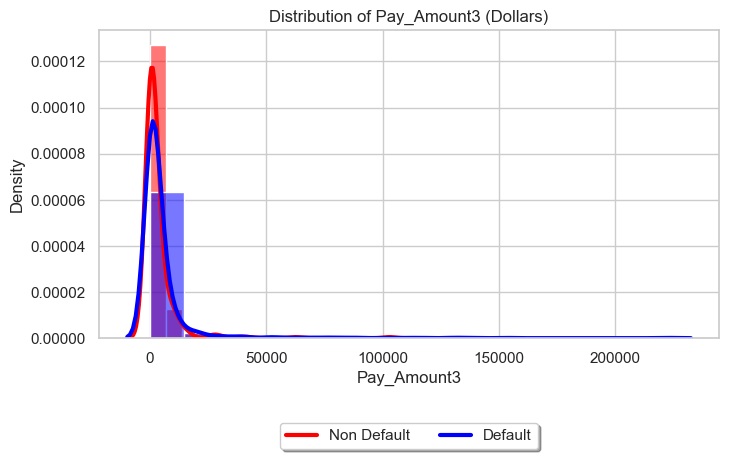

In [19]:
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 1]['Pay_Amount3'],
    density=True,
    bins=15,
    color='#ff000088'
)
plt.hist(
    credit_eda[credit_eda['Default payment next month'] == 0]['Pay_Amount3'],
    density=True,
    bins=15,
    color='#0000ff88'
)
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 1]["Pay_Amount3"], lw=3, color='#ff000088')
sns.kdeplot(credit_eda[credit_eda['Default payment next month'] == 0]["Pay_Amount3"], lw=3, color='#0000ff88')
plt.legend(
    #np.unique(credit_eda['Default payment next month']),
    labels=['Non Default', 'Default'],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    fancybox=True,
    shadow=True,
    ncol=3,
)
plt.title("Distribution of Pay_Amount3 (Dollars)")
plt.show()

* From the graphs we see that the payment features are rougly have the same distribution as each other
* Their distribution is heavily positively skewed with the right tail extending
* May need to be normalized with log scale or standard scaler

**<font size=3>
Gender Count**

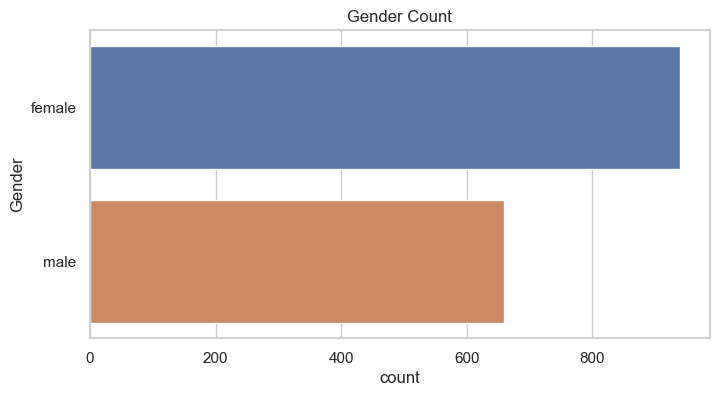

In [20]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Gender'])
plt.title('Gender Count')
plt.show()

**<font size=3>
Education Count**

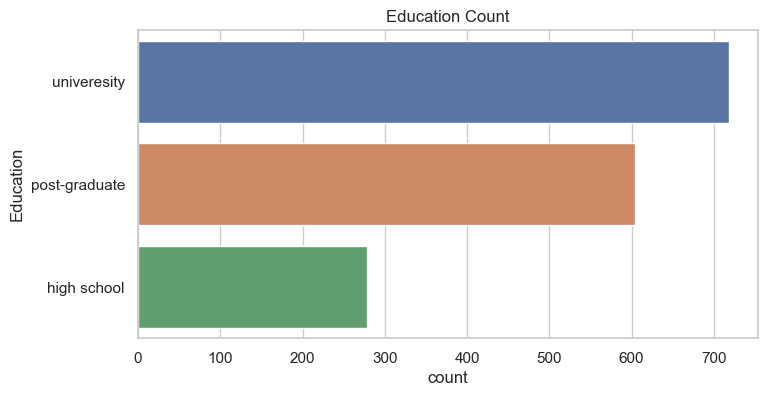

In [21]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Education'])
plt.title('Education Count')
plt.show()

**<font size=3>
Marriage Status Count**

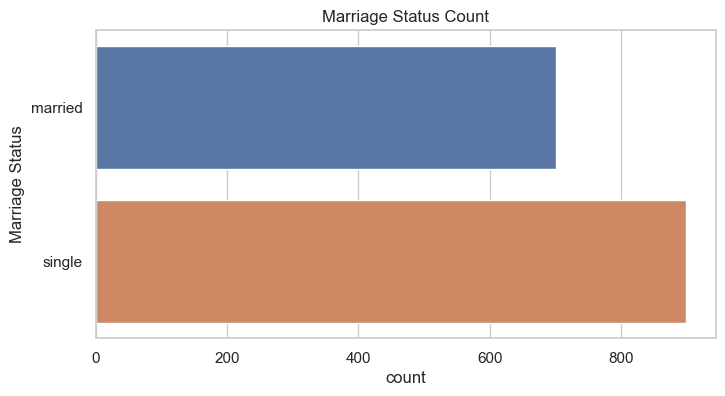

In [22]:
sns.set(rc={'figure.figsize' : (8, 4)})
sns.set_style('whitegrid')

sns.countplot(y=credit_eda['Marriage Status'])
plt.title('Marriage Status Count')
plt.show()

* Majority of customer are females
* Majority of customers have finished education at the university level
* Majority of customers are single
* Such information may be important for the model's classification, thus we will retain them and perform encoding later on

# Bivariate Analysis

**<font size=3>
Pearson Correlation**

* The Pearson coefficient is a type of correlation coefficient that represents the relationship between two variables that are measured on the same interval or ratio scale and is a measure of the strength of the association between two continuous variables.



<font size=3>
$$
r =
  \frac{ \sum(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum(x_i-\bar{x})^2\sum(y_i-\bar{y})^2}}
$$

* Where r = correlation coefficient, $x_i$ = values of the x-variable in a sample, $\bar{x}$ = mean of the values of the x-variable, $y_i$ = values of the y-variable in a sample, $\bar{x}$ = mean of the values of the y-variable

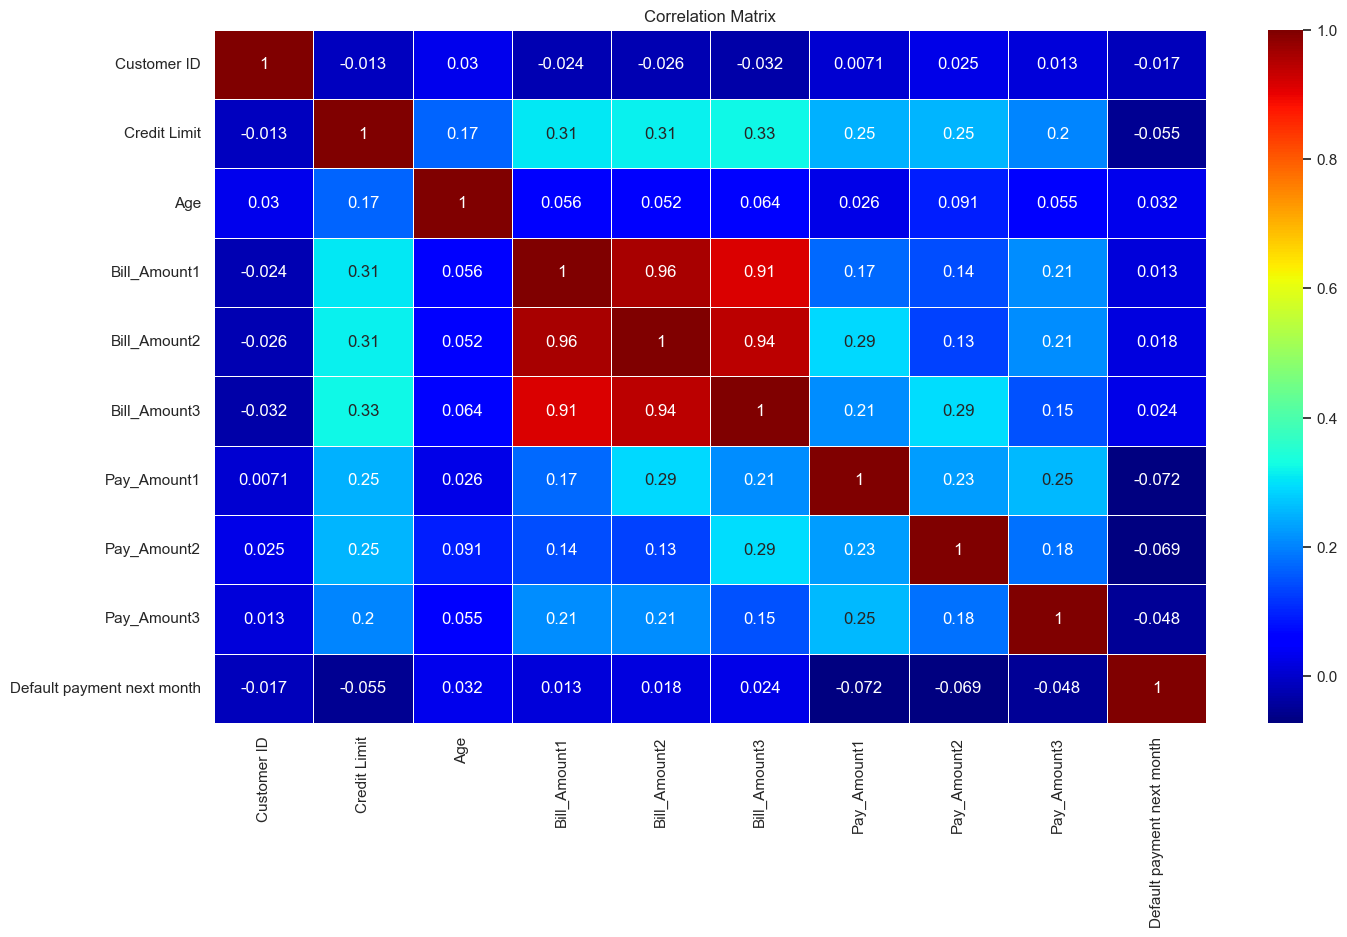

In [23]:
# Heatmap
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(credit_eda.corr(), annot=True, linewidths=.5, cmap='jet', ax=ax)
plt.title('Correlation Matrix')
plt.show()

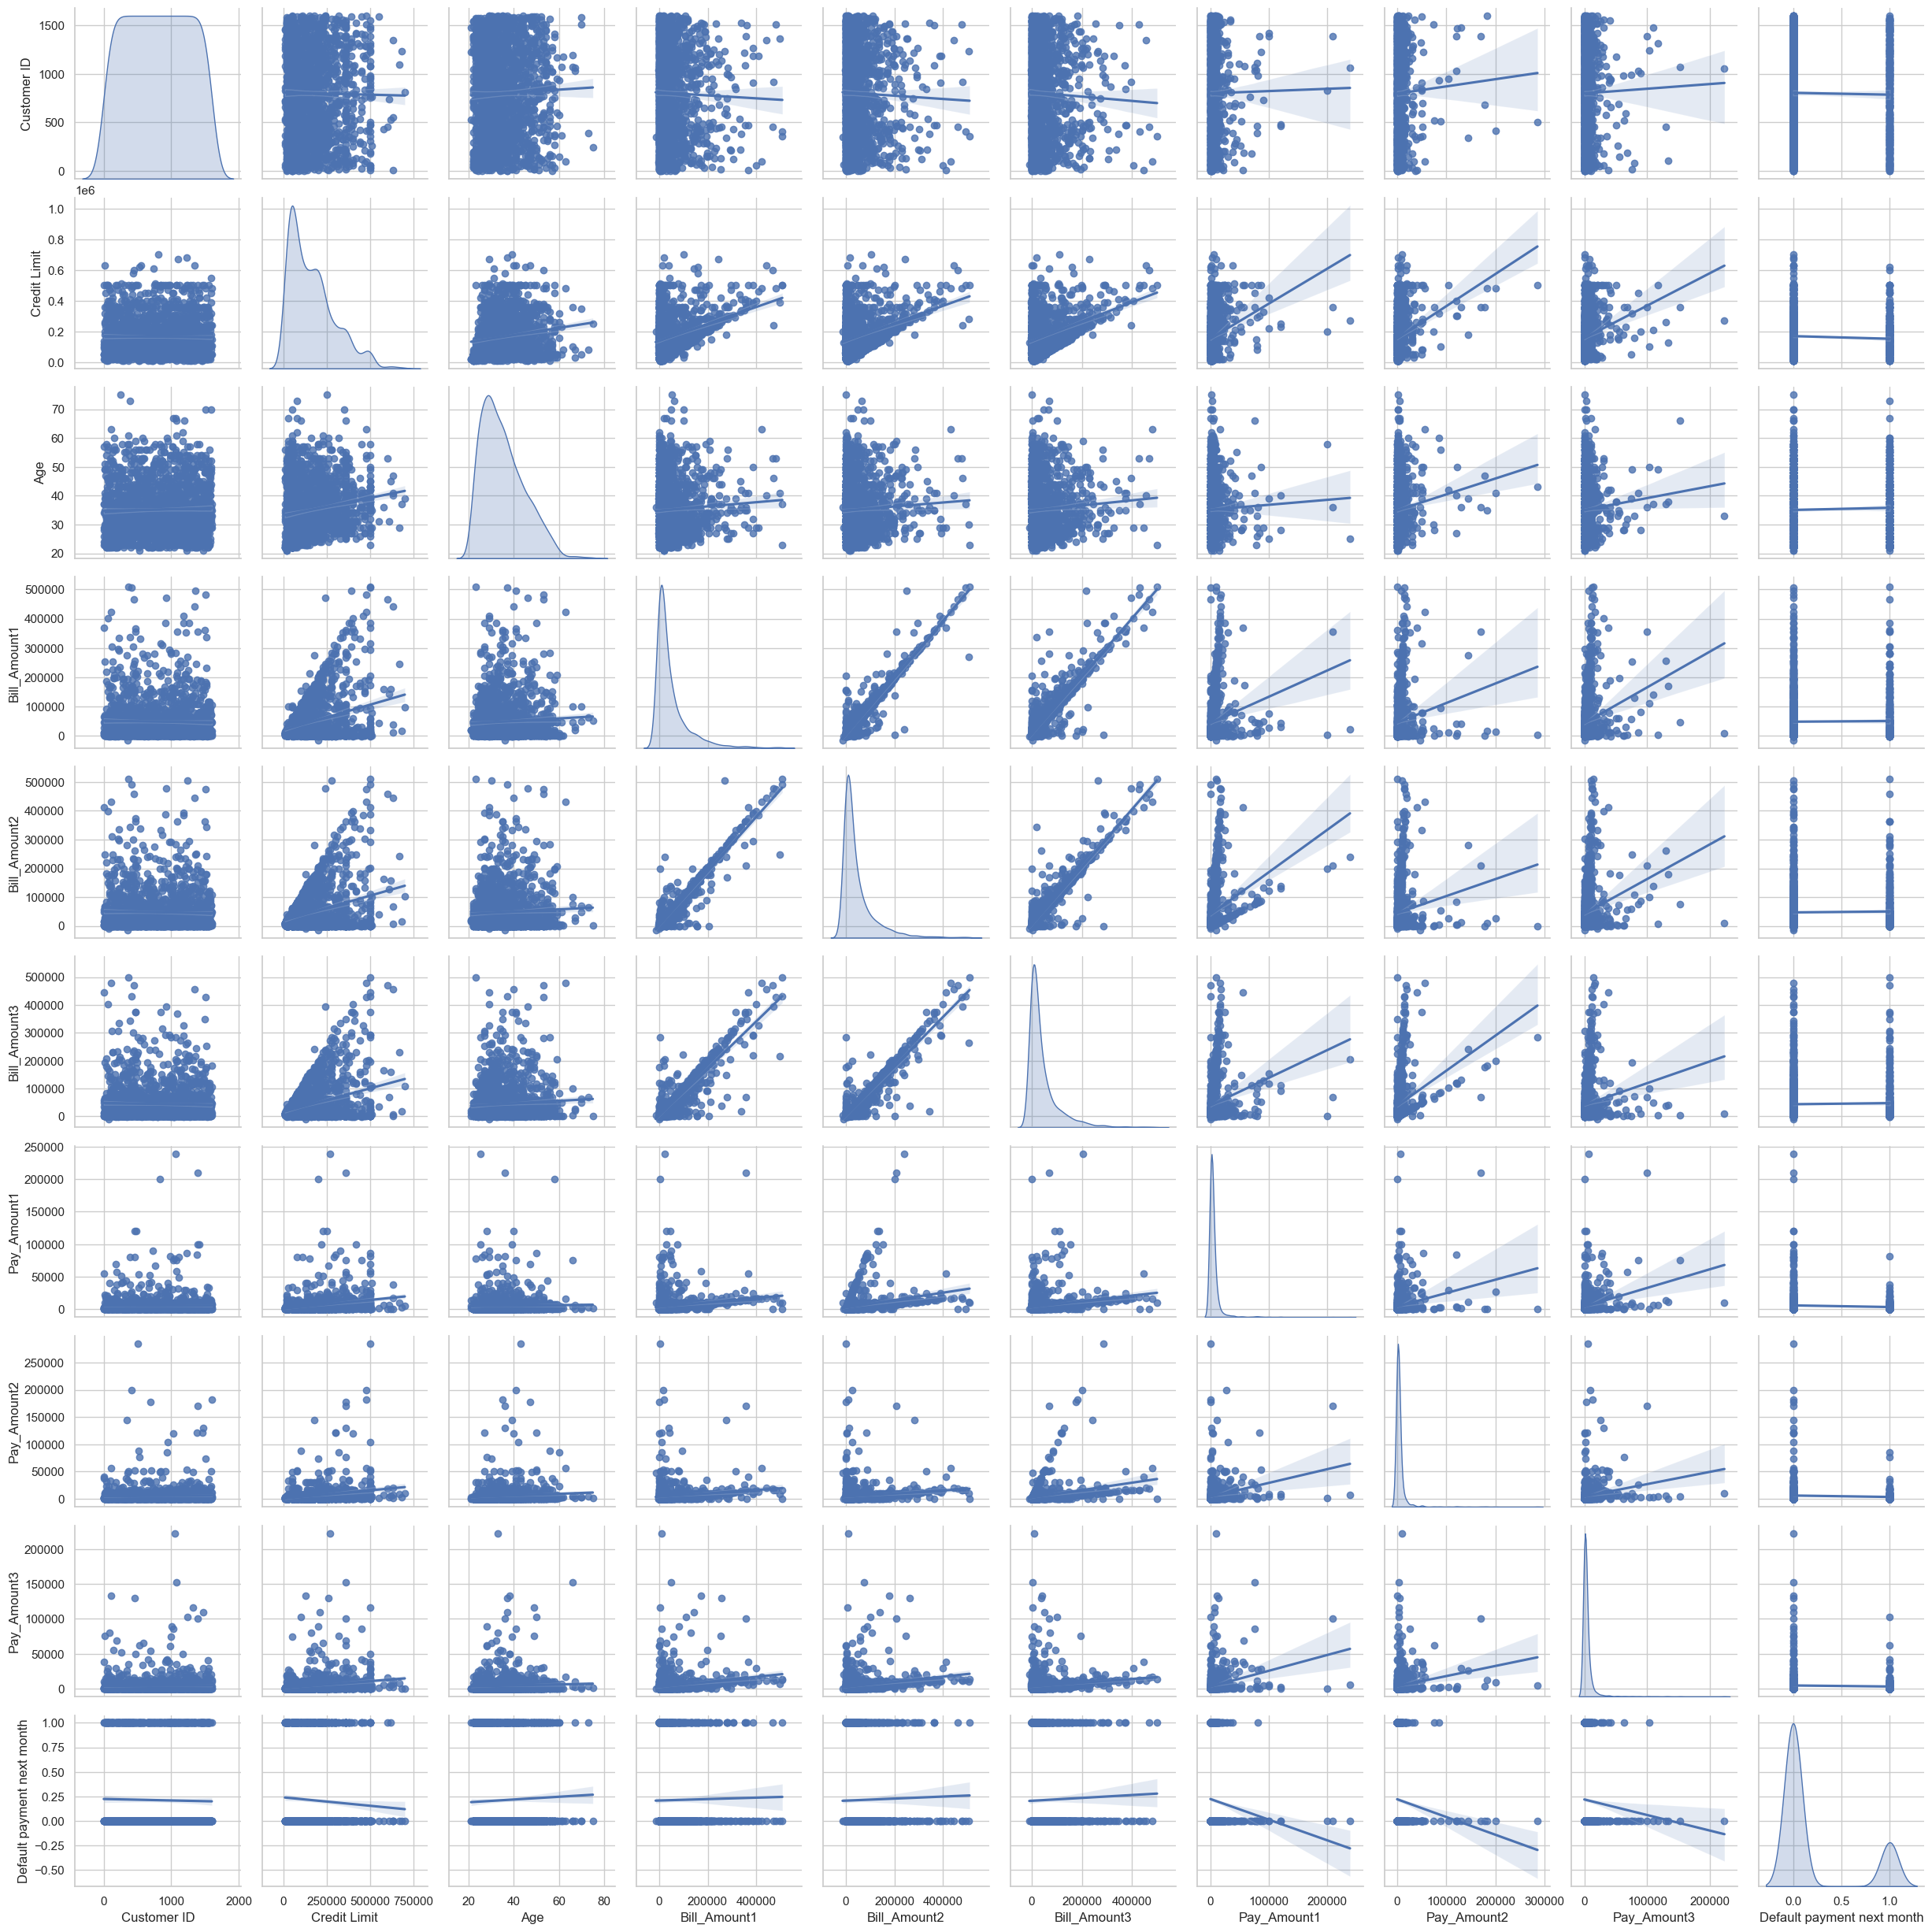

In [24]:
# Pairplot 
sns.set(style="whitegrid")
sns.pairplot(data=credit_eda, kind='reg', diag_kind='kde')
# plt.suptitle(f'{mode[0]}', y=1.01)
plt.show()

* Bill_Amount1 appears to have a very strong positive correlation with Bill_Amount2 and Bill_Amount3
* It could be because if the bill amounts are not paid off, they are accumulated 
* On the other hand, we observe that there is a weak positive relatinship between Credit and the Bill_Amount features as well as Pay_Amount features
* Lastly, we observe that Customer ID and Age have extremely weak (or close to no) correlation with other variables (and each other), prompting their removal

# Missing Values Analysis (check if we need imputation)

In [25]:
print(credit_eda.isna().sum().sort_values())

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64


* From this we can see that our data has no missing values 
* <span style ="color: green;"> This means during data preprocessing we can forgo imputation</span>

# Data Preprocessing

**Did you process the features in any way**

After analysing our features, there are a few things we need to do for data preprocessing:
1) Feature engineer new columns (total bill, total payment)
2) Scaling numerical features
3) Encode categorical features
4) Splitting features
5) Resample target feature (oversampling)

**<font size=3>
Feature Engineering**

* Based on the given columns, we can perform some aggregation
* We can create the new features: Total_Bill and Total_Payment
* Total_Bill is the sum of values of each row of Bill_Amount1, Bill_Amount2, Bill_Amount3
* Total_Payment is the sum of values of each row of Pay_Amount1, Pay_Amount2, Pay_Amount3
* We perform feature engineering first to ensure that the transformations are applied consistently during the trian-test split, and that there is no data leakage

In [26]:
credit_df['Total_Bill'] = credit_df['Bill_Amount1'] + credit_df['Bill_Amount2'] + credit_df['Bill_Amount3']
credit_df['Total_Payment'] = credit_df['Pay_Amount1'] + credit_df['Pay_Amount1'] + credit_df['Pay_Amount1']

In [27]:
credit_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,1600.0,800.500000,462.024530,1.0,400.75,800.5,1200.25,1600.0
Credit Limit,1600.0,166787.500000,129944.635707,10000.0,50000.00,140000.0,230000.00,700000.0
Age,1600.0,35.224375,9.404550,21.0,28.00,34.0,41.00,75.0
Bill_Amount1,1600.0,49263.408125,72687.106917,-14386.0,3138.00,20320.5,61602.75,507726.0
Bill_Amount2,1600.0,47726.644375,71476.217397,-13543.0,3288.25,19769.5,59891.75,509229.0
Bill_Amount3,1600.0,44531.051875,67164.064239,-9850.0,2321.50,19332.5,53857.25,499936.0
Pay_Amount1,1600.0,5547.646250,14085.471957,0.0,1000.00,2176.5,5021.00,239104.0
Pay_Amount2,1600.0,5230.494375,15569.605419,0.0,468.50,1904.0,4592.50,285138.0
Pay_Amount3,1600.0,4451.610625,12491.715387,0.0,226.50,1313.5,4000.00,222750.0
Default payment next month,1600.0,0.212500,0.409205,0.0,0.00,0.0,0.00,1.0


**<font size=3>
Normalization**

* We will use Normalizer on the data
* Normalizer transforms each sample in the data to have a unit norm
* The data will be rescaled in such a way that the values lie between -1 and 1

In [28]:
num_col = [
    "Credit Limit",
    "Bill_Amount1",
    "Bill_Amount2",
    "Bill_Amount3",
    "Pay_Amount1",
    "Pay_Amount2",
    "Pay_Amount3",
    "Total_Bill",
    "Total_Payment",
]

normalizer=Normalizer()

credit_df[num_col] = normalizer.fit_transform(credit_df[num_col])
credit_df.head(5)

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month,Total_Bill,Total_Payment
0,1,0.907933,female,univeresity,married,24,0.177637,0.140820,0.031278,0.000000,0.031278,0.000000,1,0.349736,0.000000
1,2,0.997592,female,univeresity,single,26,0.022296,0.014340,0.022296,0.000000,0.008313,0.008313,1,0.058933,0.000000
2,3,0.802074,female,univeresity,single,34,0.260576,0.125008,0.120837,0.013528,0.013368,0.008912,0,0.506420,0.040585
3,4,0.286798,female,univeresity,married,37,0.269533,0.276663,0.282732,0.011472,0.011581,0.006883,0,0.828928,0.034416
4,5,0.562962,male,univeresity,married,57,0.097021,0.063840,0.403475,0.022518,0.413000,0.112592,0,0.564336,0.067555


**<font size=2>
Visualize the standardized data**

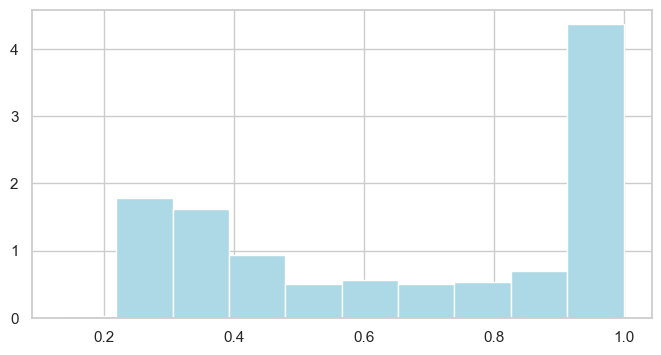

In [29]:
plt.hist(credit_df["Credit Limit"], density=True, bins=10, color="#ADD8E6")
plt.show()

**<font size=3>
Splitting features**

In [30]:
X = credit_df.drop(['Customer ID', 'Age', 'Default payment next month'], axis=1)
y = credit_df[['Default payment next month']]

* Drop Customer ID and Age from the rest of the features
* Easier preprocessing

**<font size=3>
Encode categorical features**

In [31]:
# With Column Transformer
# oe = OrdinalEncoder(categories=[['univeresity', 'post-graduate', 'high school']])

# transformers = [('Ordinal Encoder', oe, ['Education'])]

# ct = ColumnTransformer(transformers, remainder='passthrough')

# col_names = ['Education', 'Credit Limit', 'Gender', 'Marriage',
#              'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3',
#              'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3']

# X_encoded = pd.DataFrame(ct.fit_transform(X), columns=col_names)

# X_encoded.tail(10)

In [32]:
# Make copy of X to encode
X_encode = X.copy()

# Ordinal Encoder
oe = OrdinalEncoder(categories=[['univeresity', 'post-graduate', 'high school']])

# Label Encoder
le = LabelEncoder()

# Education
X_encode['Education'] = oe.fit_transform(X_encode[['Education']]) # univeresity:0.0, post-graduate:2.0, high school:2.0

# Gender
X_encode['Gender'] = le.fit_transform(X_encode[['Gender']]) # female:0, male:1

#Marriage Status
X_encode['Marriage Status'] = le.fit_transform(X_encode[['Marriage Status']]) # married:0, single:1

In [33]:
X_encode.tail(10)

,Credit Limit,Gender,Education,Marriage Status,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Total_Bill,Total_Payment
1590,0.917051,0,2.0,0,0.074538,0.109808,0.141574,0.036682,0.036682,0.018341,0.325920,0.110046
1591,0.278536,0,0.0,1,0.276402,0.280497,0.274319,0.010100,0.000000,0.012083,0.831218,0.030299
1592,0.592240,1,0.0,0,0.232688,0.230296,0.230987,0.026322,0.009871,0.009871,0.693970,0.078965
1593,0.957216,1,1.0,1,0.061549,0.043214,0.088279,0.043278,0.088774,0.080071,0.193043,0.129834
1594,0.999980,0,2.0,1,0.001562,0.001562,0.000000,0.001562,0.000000,0.000000,0.003125,0.004687
1595,0.820740,0,0.0,0,0.031144,0.018862,0.311408,0.000000,0.311408,0.022160,0.361413,0.000000
1596,0.999118,0,0.0,0,0.007886,0.005289,0.018357,0.000000,0.018464,0.000000,0.031532,0.000000
1597,0.282057,0,1.0,1,0.274864,0.280628,0.273433,0.020116,0.010257,0.010257,0.828926,0.060347
1598,0.985647,1,1.0,1,0.031804,0.029914,0.046136,0.030001,0.046256,0.041143,0.107854,0.090002
1599,0.285582,1,1.0,1,0.273319,0.282577,0.273142,0.013776,0.008567,0.002856,0.829038,0.041329


* After encoding, Education contains values: 0, 1, and 2 which map to univeresity, post-graduate, and high school respectively.
* After encoding, Gender contains values: 0, 1 which map to female and male respectively.
* After encoding, Marriage Status contains values: 0, 1 which map to married and single respectively.

**<font size=3>
Train-Test Split**

In [34]:
# Split the data into train and test sets
# Oversample target feature in the train set to prvent duplicate records in test set
X_train, X_test, y_train, y_test = train_test_split(X_encode, y, stratify=y, shuffle=True, test_size=.2, random_state=24)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1280, 12) (1280, 1)
(320, 12) (320, 1)


* To evaluate the chosen models, we do a train-test split of the data (80:20 ratio)
* We then train the model with the train data (80%)
* This allows me to simulate how my model would perform with new data or test data (20%)
* Stratifying the split ensures that the distribution of classes is the same in both the test and training set. 
* Split the dataset before oversampling to prevent data leakage

**<font size=3>
Oversampling target feature**

* There are a few techniques for oversampling, but for this project we shall compare two of the most popular ones, and see which yields better results


**<font size=2>
Random Over Sampling**
    
* A common technique used for oversampling would be random oversampling
* Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset

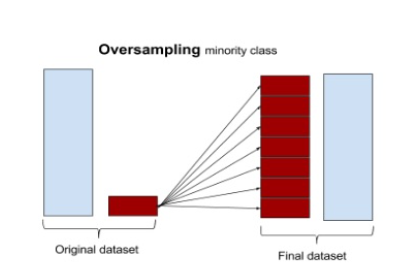

In [35]:
ros = RandomOverSampler(random_state=42)
X_random_res, y_random_res = ros.fit_resample(X_train, y_train)

print(X_random_res.shape, y_random_res.shape)

(2016, 12) (2016, 1)


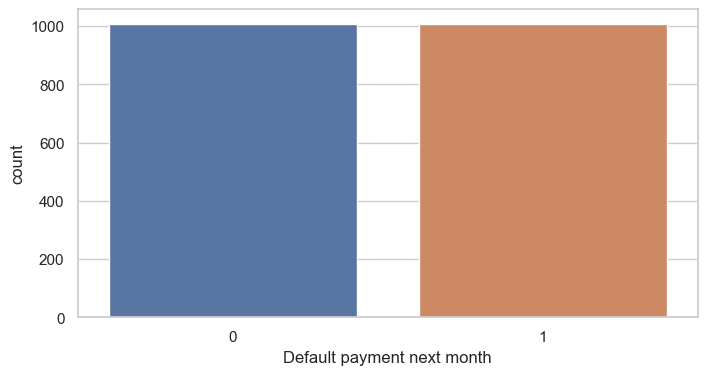

In [36]:
sns.countplot(x = 'Default payment next month', data = y_random_res)
plt.show()

**<font size=2>
SMOTE-NC**
    
* Another popular technique used for oversampling would be Synthetic Minority Over-sampling Technique for Nominal and Continuous features (SMOTE-NC) derived from SMOTE 
* We use SMOTE-NC instead of SMOTE as we have categorical features(3) and continuous features(7)

**<font size=2>
SMOTE-NC Explained**

* In SMOTE-NC, a distance metric(Euclidian and Jaccard) is first computed between the instances from the minority class. 
* The synthetic instances are then generated by selecting a minority instance and one of its k-nearest neighbors. 
    
* For nominal features, the Jaccard distance is commonly used. Simply put, the Jaccard distance measures the dissimilarity between two sets of categorical features by calculating the ratio of the size of their intersection to the size of their union.
    
* For continuous features, the Euclidean distance is often used. Simply put, the Euclidean distance measures the straight-line distance between two points in a multi-dimensional space (principle of the Pythagoras theorem).

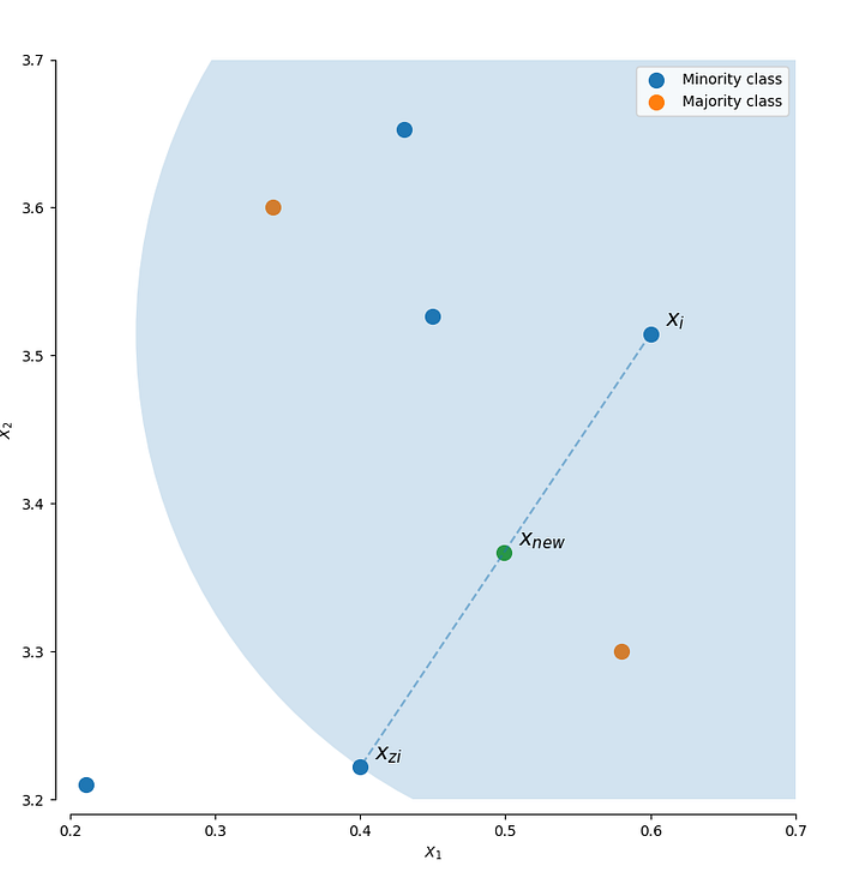 


In [37]:
categorical_features = [1, 2, 3]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_smotenc_res, y_smotenc_res = smote_nc.fit_resample(X_train, y_train)

print(X_smotenc_res.shape, y_smotenc_res.shape)

(2016, 12) (2016, 1)


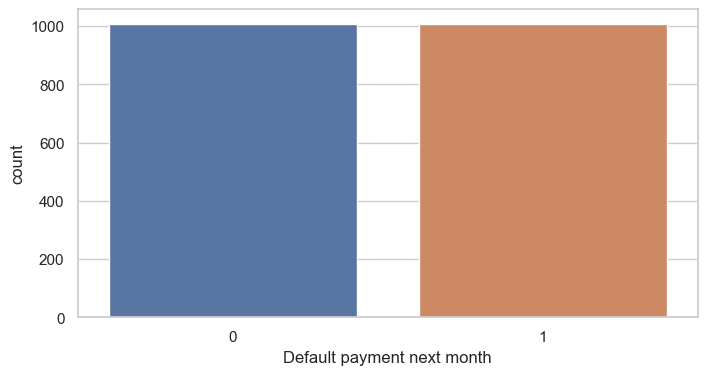

In [38]:
sns.countplot(x = 'Default payment next month', data = y_smotenc_res)
plt.show()

# Model Selection

**<font size=3>
Evaluation Methodology**

* I'll be using k-Fold Cross Validation to select candidate models after using data from the training-set
* I will then evaluate the final model using the test-set

**<font size=3>
Scoring Metrics**

* I will be using the confusion matrix and related metrics to view the performance of candidate models

**Optimizing Metric**
* In this problem, it is more important that our model is able to identify most if not all customers who might default payment in the next month.
* Hence, we aim to make use of a classification metric that focuses on obtaining high true positives (i.e. recall)

**Recall Score**
* The Recall Score is defined as follows:

<font size=4>
$$Recall = \frac{\text{True Postives}}{\text{True Positives + False Negatives}} $$

* The Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
* Thus, it is most suitable for this case as we aim to have a high score in order to correctly identify the highest amount of customers who would default payemnt

**<font size=3>
Satisficing Metrics**

**Model Interpretibility**
* The objective of the model is to help the bank identify which customer would most likey default payments in the next month, it is important for the bank to be able to identify factors used by the model
* This would allow for the bank to get a greater insight on customers likely to default payment even though they wern't identified by the model
* Hence, the model used should not be a black box, but rather show the factors that affect the final prediction. 
* This means that we will avoid black box models such as Artificial Neural Networks, and use models like Logistic Regression or Decision Trees.

**Target**
* In a dataset with such a large customers (1600), we should seek to have a higher score, around 95%-100%. 
* This is because if we fail to identify as many customers who would default loans, this would casue the banks to sustain more losses

In [39]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

* Cross Validation is done across 5 folds

In [40]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

models = [
    ("KNeighborsClassifer", KNeighborsClassifier()), 
    ("LogRegClassifier", LogisticRegression()), 
    ("DecisionTreeClassifer", DecisionTreeClassifier()), 
    ("RandomForestClassifier", RandomForestClassifier()), 
    ("GradientBoostClassifier", GradientBoostingClassifier()),
    ('SGDClassifier', SGDClassifier()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GaussianNB', GaussianNB()), # Naive Bayes
    ('ExtraTreesClassifier', ExtraTreesClassifier())
    # ('SupportVectorMachines', svm) #not correct
]

# Remember I have resampled twice (train data)
# Random Oversampling: X_random_res, y_random_res
# SMOTE-NC: X_smotenc_res, y_smotenc_res

score_random = score_models(X_random_res, y_random_res, models, metrics, cv)
score_smotenc = score_models(X_smotenc_res, y_smotenc_res, models, metrics, cv)

* Instantiating various models with default hyperparameters to pick a candidate model

**Random Oversampling Score**

In [41]:
score_random.sort_values(by=['test_precision', 'train_precision', 'test_f1', 'train_f1'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
ExtraTreesClassifier,0.403242,0.116716,0.917951,0.983127,0.950484,0.997502,0.933711,0.990258,0.975277,0.999641
RandomForestClassifier,0.569220,0.068309,0.873430,0.983127,0.961872,0.997502,0.915335,0.990258,0.969536,0.999290
DecisionTreeClassifer,0.020090,0.029339,0.785602,0.983127,0.971431,0.997502,0.868357,0.990258,0.857822,0.999641
GradientBoostClassifier,1.184410,0.047772,0.752170,0.850985,0.783409,0.871793,0.766874,0.861207,0.834952,0.934819
AdaBoostClassifier,0.279531,0.063178,0.675082,0.729759,0.685877,0.740724,0.677698,0.735032,0.738154,0.809250
KNeighborsClassifer,0.010843,0.051059,0.631962,0.736191,0.770194,0.893656,0.692886,0.807293,0.740076,0.894590
SGDClassifier,0.016737,0.057350,0.589606,0.562750,0.575275,0.555154,0.486668,0.474007,0.617879,0.597816
LogRegClassifier,0.030505,0.051519,0.588681,0.576325,0.615099,0.620767,0.598232,0.597230,0.623271,0.616102
GaussianNB,0.005573,0.032044,0.520605,0.516922,0.880694,0.882471,0.653597,0.651934,0.573149,0.559231


**SMOTE-NC Score**

In [42]:
score_smotenc.sort_values(by=['test_precision', 'train_precision', 'test_f1', 'train_f1'], ascending=False).style.apply(
    lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
).apply(
    lambda x: [
        "background-color: red; color: white" if v else "" for v in x == x.min()
    ]
)

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
ExtraTreesClassifier,0.364504,0.074557,0.808881,0.992555,0.830821,0.994041,0.819462,0.993296,0.897545,0.999816
RandomForestClassifier,0.692821,0.069032,0.778398,0.992316,0.825284,0.994284,0.801071,0.993298,0.873756,0.997975
DecisionTreeClassifer,0.035487,0.050330,0.684909,0.992555,0.728019,0.994041,0.705234,0.993296,0.694493,0.999816
KNeighborsClassifer,0.011440,0.094024,0.672510,0.761464,0.813283,0.888229,0.735920,0.819961,0.766616,0.899885
GradientBoostClassifier,0.920853,0.025537,0.665690,0.812920,0.689302,0.848672,0.676782,0.830288,0.735778,0.915991
AdaBoostClassifier,0.280607,0.047007,0.623013,0.679782,0.645452,0.722253,0.632259,0.700123,0.658303,0.766714
LogRegClassifier,0.024223,0.055816,0.598708,0.584746,0.660360,0.667115,0.626341,0.622823,0.624631,0.625356
SGDClassifier,0.015256,0.052551,0.557439,0.545268,0.665026,0.657561,0.579104,0.571813,0.600225,0.597857
GaussianNB,0.005433,0.029526,0.522304,0.524491,0.889739,0.899128,0.657849,0.662484,0.577507,0.573303


* There are a few models that perform much better compared to others, these are:
    1) ExtraTreesClassifier
    2) RandomForestClassifier
    3) DecisionTreeClassifer
    4) GradientBoostClassifier

**How did you select which learning algorithm to use?**
* Narrowing down even further further from the four aforementioned models, when observing the scores, there are two models that perform exceedingly well compared to the rest of the models across both types of (oversampled) train data
* Those models are the **ExtraTreesClassifier** and **RandomForestClassifier**

**Finalize Train Data**
* After testing models using both oversampling methods, it seems that random oversampling has produced better results
* Hence proceeding forward with building the classification model, we will be utlilizing the randomly oversampled train data 

In [43]:
X_train_final = X_random_res
y_train_final = y_random_res

# Dummy (Baseline Model)

**What is a Dummy Classifer?**

* It is a classifier model that makes predictions without trying to find patterns in the data
* The default model essentially looks at what label is most frequent in the training dataset and makes predictions based on that label

In [44]:
dummy = DummyClassifier()

dummy.fit(X_train_final, y_train_final)
cv_score = cross_validate(dummy, X_train_final, y_train_final, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
dummy_score = pd.Series(cv_score, name='dummy').apply(np.mean, axis=0)
dummy_score = pd.DataFrame(dummy_score).T
dummy_score

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
dummy,0.002015,0.036175,0.289604,0.302605,0.6,0.6,0.390536,0.402302,0.5,0.5


**Plot learning curve for dummy baseline**

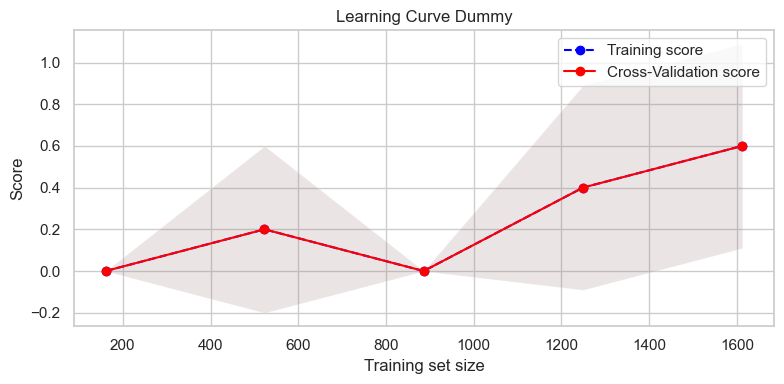

In [45]:
plot_learning_curve(DummyClassifier(), 'Dummy', X_train_final, y_train_final, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

* The baseline model performs poorly
* The learning curve shows that the model's performance on both the training set and the cross-validation set is low
* This means that the model is underfitting the data (not capturing the underlying patterns in the data as it is a dummy model)

# Extra Trees Classifier (Selected Model)

In [46]:
etc = ExtraTreesClassifier()

etc.fit(X_train_final, y_train_final)
cv_score = cross_validate(etc, X_train_final, y_train_final, scoring=metrics, cv=cv, n_jobs=2, return_train_score=True)
etc_score = pd.Series(cv_score, name='Extra Trees Classifier').apply(np.mean, axis=0)
etc_score = pd.DataFrame(etc_score).T
etc_score

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
Extra Trees Classifier,0.307965,0.072477,0.920972,0.983127,0.951565,0.997502,0.935739,0.990258,0.976019,0.999641


**Plot learning curve for selected model**

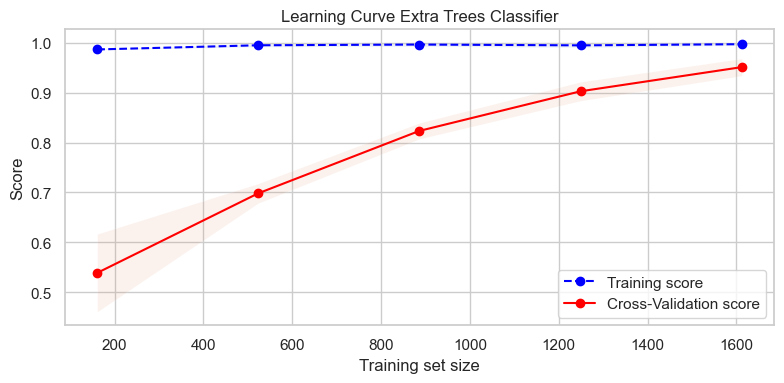

In [47]:
plot_learning_curve(ExtraTreesClassifier(), 'Extra Trees Classifier', X_train_final, y_train_final, cv=cv, n_jobs=-1)
plt.tight_layout()
plt.show() 

* The Extra Trees Classifier performs well as we see that the gaps of both the train and cross-validation score are close together
* This symbolises that our model has low variance
* Aside from that, both of our learning curves do not converge at a low score
* This symbolises that our model has low bias
* All in all, this is a good candidate for our final model

# Comparing Baseline and Selected Model

**How well does your system compare to a dummy baseline?**

**Can you say anything about the errors that the system makes?**

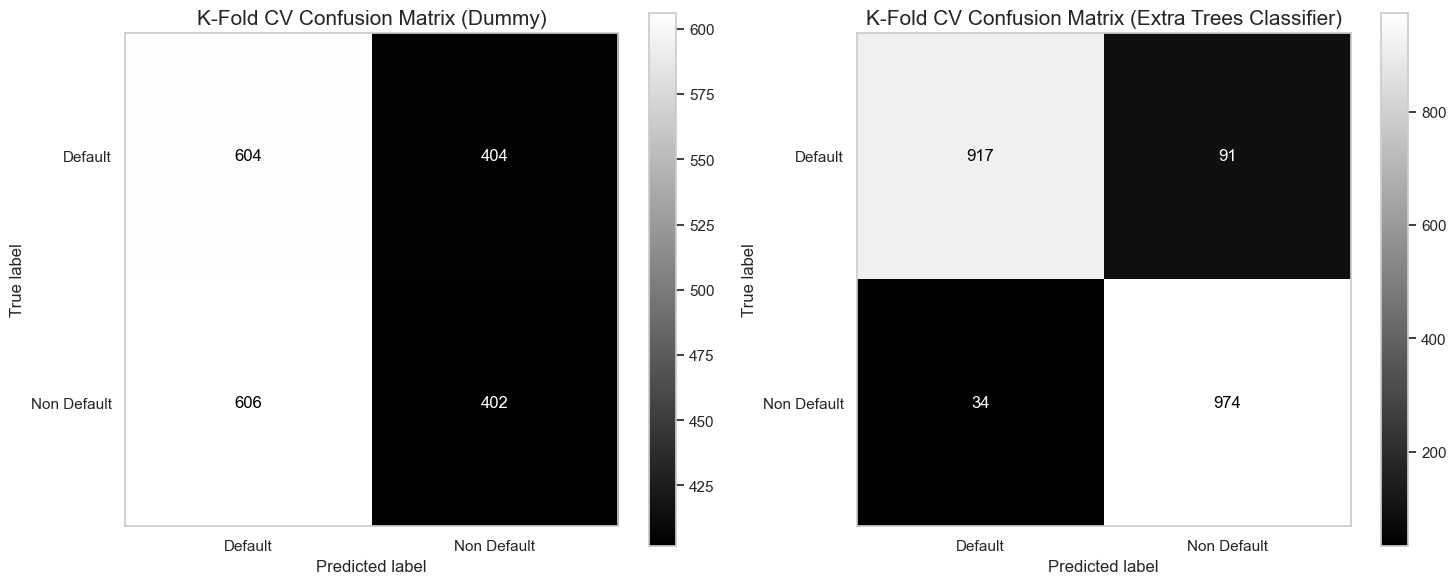

In [48]:
dummy = DummyClassifier()
etc = ExtraTreesClassifier()

labels = ['Default', 'Non Default']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

dummy.fit(X_train_final, y_train_final)
pred_d = cross_val_predict(dummy, X_train_final, y_train_final)
cm_d = confusion_matrix(y_train_final, pred_d) 
disp_d = ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=labels)
disp_d.plot(ax=axes[0], cmap='gist_gray')
axes[0].grid(False)
axes[0].set_title(f'K-Fold CV Confusion Matrix (Dummy)', fontsize=15)

etc.fit(X_train_final, y_train_final)
pred_e = cross_val_predict(etc, X_train_final, y_train_final)
cm_e = confusion_matrix(y_train_final, pred_e) 
disp_e = ConfusionMatrixDisplay(confusion_matrix=cm_e, display_labels=labels)
disp_e.plot(ax=axes[1], cmap='gist_gray')
axes[1].grid(False)
axes[1].set_title(f'K-Fold CV Confusion Matrix (Extra Trees Classifier)', fontsize=15)

plt.tight_layout()
plt.show()

* From the confusion matrix, we observe that the Extra Trees Classifier performs well with K-Fold cross validation and has little false positives and negatives
* Compared to the Extra Trees Classifier, we observe that the baseline fares worser, having almost as many false predictions as true predictions (random)

# Hyperparameter Tuning

**Did you try to tune the hyperparameters of the learning algorithm, and in that case how?**

* For hyperparamter tuning, I will use GridSearchCV
* GridSearchCV tries all the combinations of the values passed in the dictionary for a hyperparameter and evaluates the model for each combination using the Cross-Validation method
* Using this function allows us to get the optimal set of hyperparameters of every combination of hyperparameters 

**Hyperparamters of Extra Trees Classifier**

In [49]:
print("Extra Trees Classifier Hyperparameters:")
print("======================================")
for param_name in etc.get_params().keys():
    print(param_name)

Extra Trees Classifier Hyperparameters:
bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [50]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
min_samples_leaf = [1, 2, 4, 8]
max_features = ['auto', 'sqrt', 'log2']

params = {
    'n_estimators' : n_estimators,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}

etc_cv = GridSearchCV(etc, param_grid=params, n_jobs=-1, scoring='recall')
etc_cv.fit(X_train_final, y_train_final)

n_estimators = etc_cv.best_params_['n_estimators']
min_samples_leaf = etc_cv.best_params_['min_samples_leaf']
max_features = etc_cv.best_params_['max_features']

for param in etc_cv.best_params_:
    print(f'{param}: {etc_cv.best_params_[param]}')

print(etc_cv.best_score_)

max_features: auto
min_samples_leaf: 1
n_estimators: 50
0.9682527954287966


# Extra Trees Classifier with tuned hyperparamters

* I will now train an Extra Trees Classifier model with the optimal parameter values

In [51]:
etc_tuned = ExtraTreesClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features)
etc_tuned.fit(X_train_final, y_train_final)

pred = etc_tuned.predict(X_test)
cv_score = cross_val_score(etc_tuned, X_train_final, y_train_final, cv=cv, scoring='recall')

print(classification_report(y_test, pred, digits=3))
print(np.mean(cv_score))

              precision    recall  f1-score   support

           0      0.804     0.929     0.862       252
           1      0.379     0.162     0.227        68

    accuracy                          0.766       320
   macro avg      0.592     0.545     0.544       320
weighted avg      0.714     0.766     0.727       320

0.9494893720709514


# Validation Curves

* A validation curve helps visualize the performance of our model over different values for hyperparamters

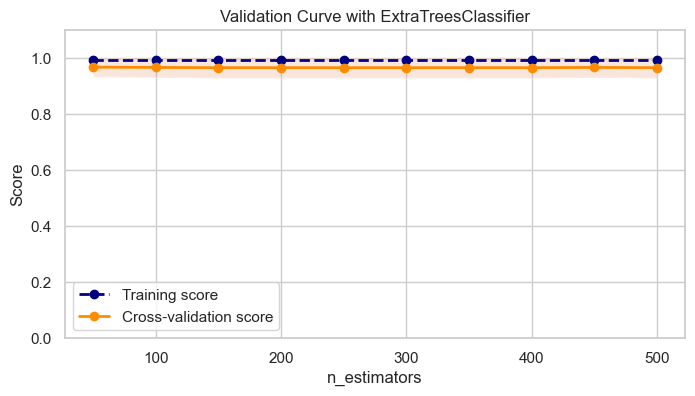

In [52]:
plot_validation_curve_range(etc, X_train_final, y_train_final, 'n_estimators', [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)])
plt.show()

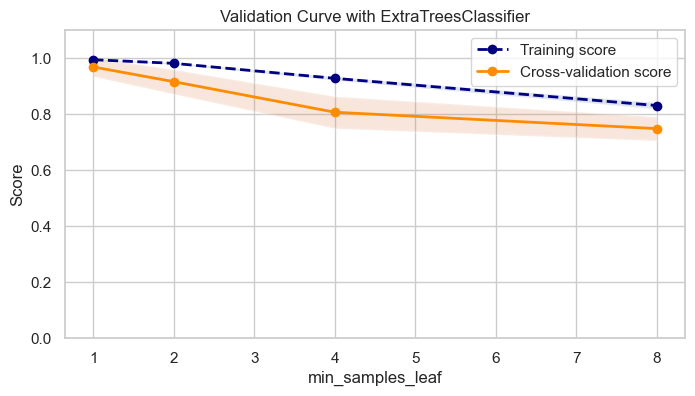

In [53]:
plot_validation_curve_range(etc, X_train_final, y_train_final, 'min_samples_leaf', [1, 2, 4, 8])
plt.show()

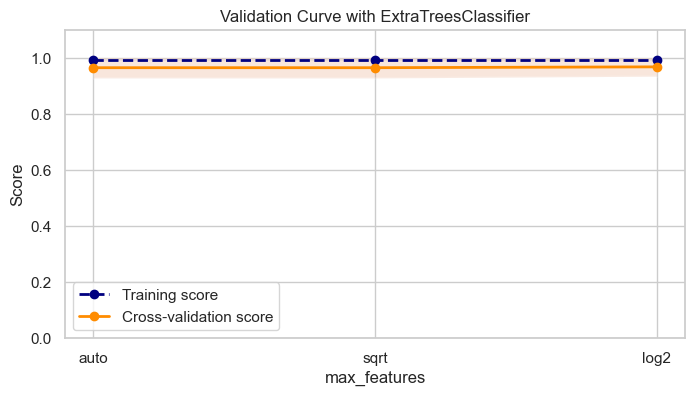

In [54]:
plot_validation_curve_range(etc, X_train_final, y_train_final, 'max_features', ['auto', 'sqrt', 'log2'])
plt.show()

# Final Model


* Evaluate the model using the test set and see how well it performs

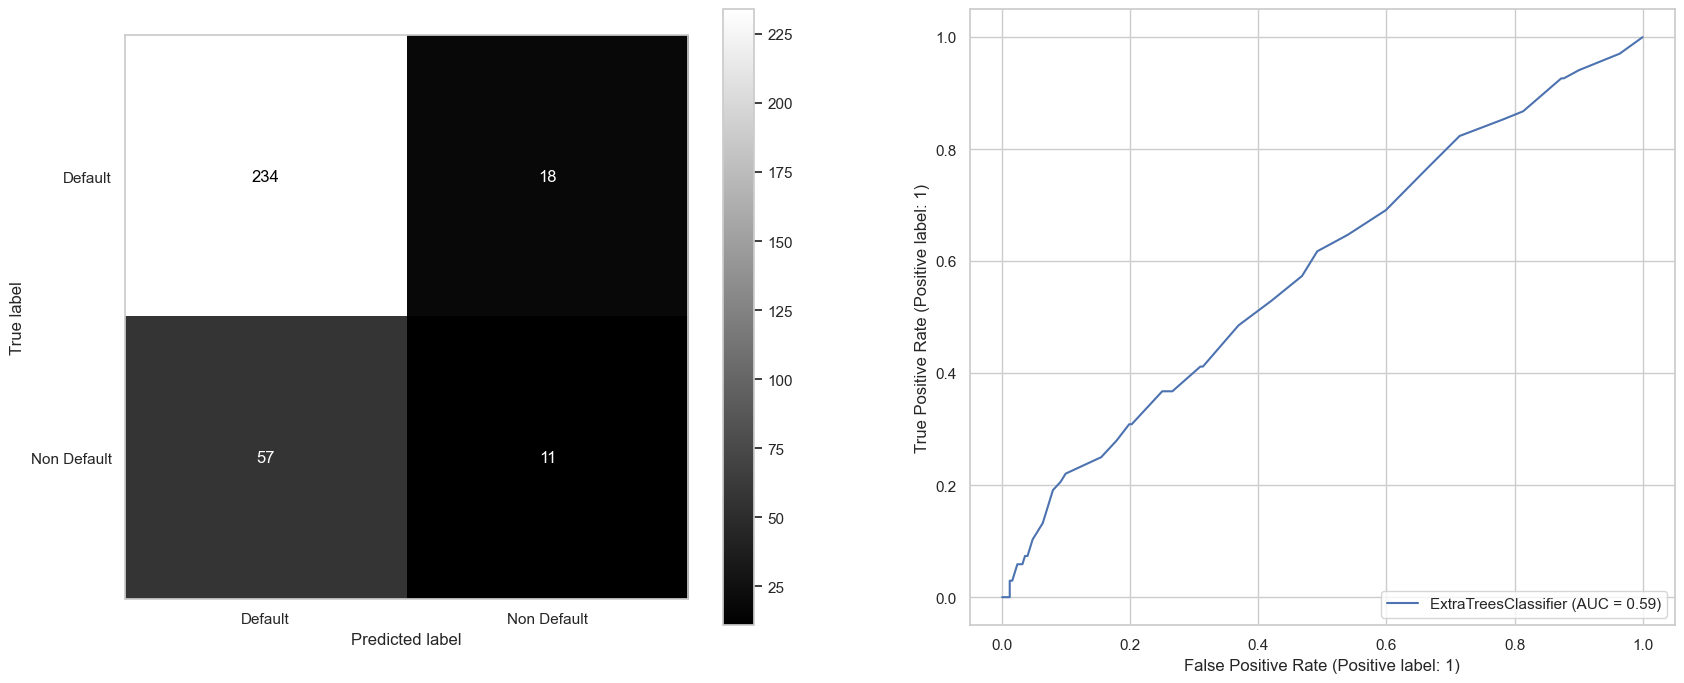

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

y_pred = etc_tuned.predict(X_test) 
cm = confusion_matrix(y_test, y_pred) 

display_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display_test.plot(ax=axes[0], cmap='gist_gray')

RocCurveDisplay.from_estimator(etc_tuned, X_test, y_test, ax=axes[1])
#Plotting the graphs
axes[0].grid(None)
plt.show()

# Feature Importance

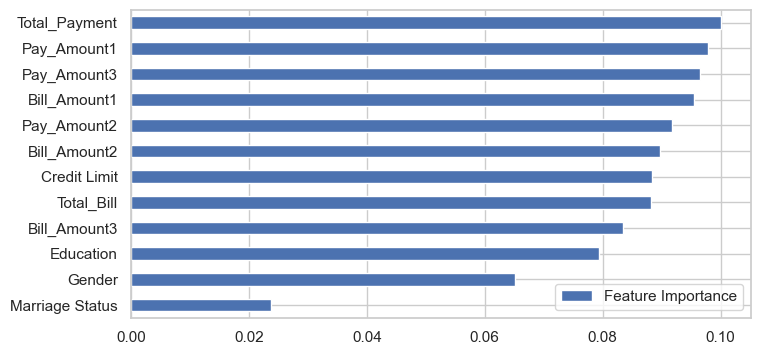

In [56]:
ft_impt = pd.DataFrame(etc_tuned[-1].feature_importances_, index=X_train.columns, columns=["Feature Importance"]).sort_values("Feature Importance")
ft_impt.plot(kind='barh')
plt.legend(loc='best')
plt.show()